# Previsión de Falla

### Descripción
Los galpones de Full de mercado libre cuentan con una flota de dispositivos que transmiten diariamente telemetría agregada en varios atributos.
Las técnicas de mantenimiento predictivo están diseñadas para ayudar a determinar la condición del equipo de mantenimiento en servicio para predecir cuándo se debe realizar el mantenimiento. Este enfoque promete ahorros de costos sobre el mantenimiento preventivo
de rutina o basado en el tiempo porque las tareas se realizan solo cuando están justificadas.

### Entregable
El objetivo es generar un notebook Jupyter con un modelo para predecir la probabilidad de falla del dispositivo un día antes de la posible falla , se debe utilizar una time series para ayudar el modelo.
El archivo "full_devices.csv" tiene los valores diários para los 9 atributos de los dispositivos y la columna que está tratando de predecir se llama 'failure' con el valor binario 0 para no fallar y 1 para fallar, la colunas device tenes id del dispositivos.

## Importando las bibliotecas

In [105]:
pip install prophet

  Using cached holidays-0.58-py3-none-any.whl.metadata (26 kB)
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ----- ---------------------------------- 1.7/13.3 MB 54.8 MB/s eta 0:00:01
   -------------------- ------------------- 6.9/13.3 MB 88.0 MB/s eta 0:00:01
   ------------------------------------- -- 12.5/13.3 MB 131.2 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 81.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/94.5 kB ? eta -:--:--
   ---------------------------------------- 94.5/94.5 kB 5.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 35.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [215]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

## Importando los datos

In [218]:
df_devices = pd.read_csv("full_devices.csv", encoding='ISO-8859-1')

In [220]:
df_devices

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
124489,2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0
124490,2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13
124491,2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0


In [222]:
df_devices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [224]:
df_devices['date'] = pd.to_datetime(df_devices['date'], format='%Y-%m-%d')

In [226]:
df_devices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        124494 non-null  datetime64[ns]
 1   device      124494 non-null  object        
 2   failure     124494 non-null  int64         
 3   attribute1  124494 non-null  int64         
 4   attribute2  124494 non-null  int64         
 5   attribute3  124494 non-null  int64         
 6   attribute4  124494 non-null  int64         
 7   attribute5  124494 non-null  int64         
 8   attribute6  124494 non-null  int64         
 9   attribute7  124494 non-null  int64         
 10  attribute8  124494 non-null  int64         
 11  attribute9  124494 non-null  int64         
dtypes: datetime64[ns](1), int64(10), object(1)
memory usage: 11.4+ MB


In [228]:
df_devices['date'].min()

Timestamp('2015-01-01 00:00:00')

In [230]:
df_devices['date'].max()

Timestamp('2015-11-02 00:00:00')

In [232]:
df_devices.shape

(124494, 12)

In [234]:
df_device_days = df_devices["device"].value_counts().reset_index()

In [236]:
df_device_days

,device,count
0,Z1F0QLC1,304
1,S1F0KYCR,304
2,S1F0E9EP,304
3,S1F0EGMT,304
4,S1F0FGBQ,304
...,...,...
1164,W1F1CHZK,5
1165,W1F1CJKT,5
1166,S1F04KSC,4
1167,W1F0WJFT,3


Nos damos cuenta de que muchos dispositivos no tienen datos de mantenimiento para todos los días del período, algunos de ellos porque comenzaron a registrar datos en la mitad del período (quizás sean dispositivos más nuevos) y otros porque detuvieron su monitoreo en un momento determinado (quizás dispositivos que ya no están en actividad). Si tuviéramos más información sobre el contexto, podríamos entender si existen dispositivos que han sido desactivados y, por lo tanto, no tendría sentido crear una previsión de monitoreo para ellos. De cualquier manera, con los datos que tenemos, podríamos excluir de las predicciones los dispositivos que tienen muy poco tiempo de monitoreo, o podríamos separarlos del entrenamiento y hacer predicciones para ellos basadas en las predicciones realizadas para dispositivos similares. O, como lo haré aquí, utilizar un método ensemble de machine learning, XGBoost, que es capaz de hacer predicciones incluso con la falta de datos durante el período. Otro punto que favorece el uso de ensemble es la cantidad de dispositivos, como son muchos (1.169), no valdría la pena utilizar modelos tradicionales de series temporales como ARIMAX o Prophet, que necesitarían ser entrenados para cada dispositivo. A menos que, antes de utilizar estos métodos, se creara un modelo para categorizar los dispositivos y, posteriormente, generar la previsión de fallas para la categoría del dispositivo.

In [239]:
df_device_days.loc[df_device_days["count"] < 304]

,device,count
27,W1F0T0B1,299
28,W1F1N6V6,295
29,W1F19J5Q,295
30,S1F13CMG,295
31,Z1F11SYE,295
...,...,...
1164,W1F1CHZK,5
1165,W1F1CJKT,5
1166,S1F04KSC,4
1167,W1F0WJFT,3


In [241]:
df_device_days.loc[df_device_days["count"] < 30]

,device,count
737,W1F0FW0S,28
738,S1F0S57T,26
739,W1F0Z4EA,26
740,S1F0LCTV,26
741,S1F0HWXJ,26
...,...,...
1164,W1F1CHZK,5
1165,W1F1CJKT,5
1166,S1F04KSC,4
1167,W1F0WJFT,3


Voy a excluir del análisis los dispositivos que tienen menos de 90 días de datos históricos de mantenimiento. Después se poderá suponer la falla de estos dispositivo por similaridad a losque tenemos datos.

In [244]:
df_valid_device = df_device_days.loc[df_device_days["count"] > 90]
df_devices = df_devices.merge(df_valid_device[["device"]], on="device", how = "inner")

In [246]:
df_valid_device

,device,count
0,Z1F0QLC1,304
1,S1F0KYCR,304
2,S1F0E9EP,304
3,S1F0EGMT,304
4,S1F0FGBQ,304
...,...,...
493,W1F0VFRE,95
494,S1F0QWGA,94
495,W1F0VAS7,93
496,W1F1CDDP,93


Voy a selecionar los dispositivos que tuvieron historico de falla, por no se poder suponer lo periodo de falla para dispositivos que nunca fallaron

In [249]:
df_valid_failure = df_devices.groupby("device").agg({"failure":"sum"})

In [251]:
df_valid_failure = df_valid_failure.loc[df_valid_failure["failure"] > 0]

In [253]:
df_valid_failure

,failure
device,
S1F03YZM,1
S1F09DZQ,1
S1F0F4EB,1
S1F0GKFX,1
S1F0GKL6,1
S1F0GPFZ,1
S1F0GSD9,1
S1F0GSHB,1
S1F0J5JH,1


In [255]:
df_devices = df_devices.merge(df_valid_failure.reset_index()[["device"]], on="device", how = "inner")

In [257]:
df_devices

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F03YZM,0,55587136,0,0,0,7,199132,0,0,0
1,2015-01-01,S1F09DZQ,0,12568128,136,0,2,6,380112,0,0,2
2,2015-01-01,S1F0F4EB,0,239412320,0,0,0,9,200197,0,0,2
3,2015-01-01,S1F0GKFX,0,107148272,0,0,0,65,223170,0,0,0
4,2015-01-01,S1F0GKL6,0,234778096,0,0,0,90,221425,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8876,2015-10-22,W1F0T0B1,0,112824920,0,0,0,9,352949,16,16,0
8877,2015-10-23,W1F0T0B1,0,52620456,0,0,0,9,352949,16,16,0
8878,2015-10-24,W1F0T0B1,0,154144032,0,0,0,9,352949,16,16,0
8879,2015-10-25,W1F0T0B1,0,86280056,0,0,7,9,354072,22,22,0


Voy a completar con todas las fechas los dispositivos que quedaron

In [260]:
all_dates = pd.date_range(start=df_devices['date'].min(), end=df_devices['date'].max())

In [262]:
all_dates

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2015-10-17', '2015-10-18', '2015-10-19', '2015-10-20',
               '2015-10-21', '2015-10-22', '2015-10-23', '2015-10-24',
               '2015-10-25', '2015-10-26'],
              dtype='datetime64[ns]', length=299, freq='D')

In [264]:
all_devices = df_devices["device"].drop_duplicates()

Quedaron 53 dispositivos

In [267]:
all_devices

0     S1F03YZM
1     S1F09DZQ
2     S1F0F4EB
3     S1F0GKFX
4     S1F0GKL6
5     S1F0GPFZ
6     S1F0GSD9
7     S1F0GSHB
8     S1F0J5JH
9     S1F0JD7P
10    S1F0JGJV
11    S1F0L0DW
12    S1F0LCVC
13    S1F0LD15
14    S1F0QF3R
15    S1F0RSZP
16    S1F0S4EG
17    S1F0S65X
18    S1F0T2LA
19    S1F13589
20    S1F135TN
21    S1F136J0
22    S1F13H80
23    W1F03D4L
24    W1F0FKWW
25    W1F0GCAZ
26    W1F0KCP2
27    W1F0M35B
28    W1F0M4BZ
29    W1F0PAXH
30    W1F0T0B1
31    W1F0WBTM
32    W1F0Z3KR
33    W1F11ZG9
34    W1F14XGD
35    W1F1BFP5
36    W1F1BS0H
37    W1F1BZTM
38    W1F1C9WG
39    W1F1CB5E
40    W1F1CDDP
41    W1F1CJ1K
42    W1F1DQN8
43    Z1F0B4XZ
44    Z1F0K451
45    Z1F0LSNZ
46    Z1F0MRPJ
47    Z1F0P16F
48    Z1F148T1
49    Z1F14BGY
50    Z1F1653X
51    Z1F1901P
52    Z1F1RJFA
53    Z1F1VQFY
Name: device, dtype: object

Voy completar lo historico de estos dispositivos con todas las datas del periodo

In [270]:
df_complete = pd.DataFrame()

In [272]:
for i in all_devices:
    df_each_device = pd.DataFrame()
    df_each_device["date"] = all_dates
    df_each_device["device"] = i
    df_complete = pd.concat([df_complete, df_each_device])

In [274]:
df_complete

,date,device
0,2015-01-01,S1F03YZM
1,2015-01-02,S1F03YZM
2,2015-01-03,S1F03YZM
3,2015-01-04,S1F03YZM
4,2015-01-05,S1F03YZM
...,...,...
294,2015-10-22,Z1F1VQFY
295,2015-10-23,Z1F1VQFY
296,2015-10-24,Z1F1VQFY
297,2015-10-25,Z1F1VQFY


In [276]:
df_complete_device = df_complete.merge(df_devices, on = ["date", "device"], how = "left")

In [278]:
df_complete_device = df_complete_device.fillna(0)

In [280]:
df_complete_device

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F03YZM,0.0,55587136.0,0.0,0.0,0.0,7.0,199132.0,0.0,0.0,0.0
1,2015-01-02,S1F03YZM,0.0,75670840.0,0.0,0.0,0.0,7.0,200488.0,0.0,0.0,0.0
2,2015-01-03,S1F03YZM,0.0,95736464.0,0.0,0.0,0.0,7.0,201873.0,0.0,0.0,0.0
3,2015-01-04,S1F03YZM,0.0,118494816.0,0.0,0.0,0.0,7.0,203215.0,0.0,0.0,0.0
4,2015-01-05,S1F03YZM,0.0,140199000.0,0.0,0.0,0.0,7.0,204540.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
16141,2015-10-22,Z1F1VQFY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16142,2015-10-23,Z1F1VQFY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16143,2015-10-24,Z1F1VQFY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16144,2015-10-25,Z1F1VQFY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [282]:
df_complete_device.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16146 entries, 0 to 16145
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        16146 non-null  datetime64[ns]
 1   device      16146 non-null  object        
 2   failure     16146 non-null  float64       
 3   attribute1  16146 non-null  float64       
 4   attribute2  16146 non-null  float64       
 5   attribute3  16146 non-null  float64       
 6   attribute4  16146 non-null  float64       
 7   attribute5  16146 non-null  float64       
 8   attribute6  16146 non-null  float64       
 9   attribute7  16146 non-null  float64       
 10  attribute8  16146 non-null  float64       
 11  attribute9  16146 non-null  float64       
dtypes: datetime64[ns](1), float64(10), object(1)
memory usage: 1.5+ MB


In [284]:
df_complete_device['failure'] = df_complete_device['failure'].astype(int)     
df_complete_device['attribute1'] = df_complete_device['attribute1'].astype(int)      
df_complete_device['attribute2'] = df_complete_device['attribute2'].astype(int)        
df_complete_device['attribute3'] = df_complete_device['attribute3'].astype(int)      
df_complete_device['attribute4'] = df_complete_device['attribute4'].astype(int)        
df_complete_device['attribute5'] = df_complete_device['attribute5'].astype(int)        
df_complete_device['attribute6'] = df_complete_device['attribute6'].astype(int)      
df_complete_device['attribute7'] = df_complete_device['attribute7'].astype(int)        
df_complete_device['attribute8'] = df_complete_device['attribute8'].astype(int)      
df_complete_device['attribute9'] = df_complete_device['attribute9'].astype(int)   

Para utilizar modelos de series temporales como Prophet y ARIMA, se podría considerar para dispositivos con historiales suficientemente largos. Sin embargo, dado que tienes más de 1000 dispositivos, entrenar modelos individuales por dispositivo es computacionalmente costoso y no escalable.

Una solución escalable sería categorizar los dispositivos en diferentes grupos (basados en sus patrones de telemetría) y luego entrenar modelos de series temporales para cada grupo. De esta manera, reduces la carga del entrenamiento individual de modelos. Una vez que hayas creado las características, puedes utilizar algoritmos de agrupamiento como K-Means, DBSCAN o agrupamiento jerárquico para agrupar dispositivos según sus patrones de telemetría.

Agrupamiento K-Means: Para categorizar dispositivos en diferentes grupos basados en sus patrones de telemetría y luego entrenar modelos de series temporales para cada grupo, puedes seguir un enfoque sistemático. El objetivo es agrupar dispositivos que comparten comportamientos similares, lo que permite un entrenamiento más eficiente del modelo en lugar de entrenar modelos individuales para cada dispositivo. Es un algoritmo comúnmente utilizado para categorizar dispositivos en grupos basados en la similitud de sus datos de telemetría.

In [287]:
df_complete_device_agg = df_complete_device.groupby("device").agg({'failure': 'sum', 'attribute1': 'mean', 'attribute2': 'mean', 'attribute3':'mean', 'attribute4': 'mean', 'attribute5': 'mean', 'attribute6': 'mean', 'attribute7': 'mean', 'attribute8': 'mean', 'attribute9': 'mean'})

In [289]:
# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_complete_device_agg)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # You can adjust the number of clusters
df_complete_device_agg['cluster'] = kmeans.fit_predict(scaled_features)

# Now each device is assigned to a cluster
print(df_complete_device_agg[['cluster']])

          cluster
device           
S1F03YZM        0
S1F09DZQ        0
S1F0F4EB        2
S1F0GKFX        2
S1F0GKL6        2
S1F0GPFZ        0
S1F0GSD9        2
S1F0GSHB        2
S1F0J5JH        0
S1F0JD7P        2
S1F0JGJV        1
S1F0L0DW        2
S1F0LCVC        2
S1F0LD15        0
S1F0QF3R        2
S1F0RSZP        2
S1F0S4EG        0
S1F0S65X        0
S1F0T2LA        0
S1F13589        2
S1F135TN        0
S1F136J0        2
S1F13H80        2
W1F03D4L        2
W1F0FKWW        2
W1F0GCAZ        2
W1F0KCP2        2
W1F0M35B        2
W1F0M4BZ        2
W1F0PAXH        0
W1F0T0B1        0
W1F0WBTM        2
W1F0Z3KR        2
W1F11ZG9        0
W1F14XGD        0
W1F1BFP5        0
W1F1BS0H        0
W1F1BZTM        1
W1F1C9WG        2
W1F1CB5E        2
W1F1CDDP        1
W1F1CJ1K        0
W1F1DQN8        1
Z1F0B4XZ        2
Z1F0K451        2
Z1F0LSNZ        0
Z1F0MRPJ        0
Z1F0P16F        0
Z1F148T1        1
Z1F14BGY        0
Z1F1653X        1
Z1F1901P        2
Z1F1RJFA        0
Z1F1VQFY  

C:\Users\suzic\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Estoy usando PCA para visualizar los datos de cluster

In [292]:
# Step 1: Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_complete_device_agg[["attribute1", "attribute2", "attribute3", "attribute4", "attribute5", "attribute6", "attribute7", "attribute8", "attribute9"]])

# Step 2: Apply PCA
# Define the number of components you want to keep (e.g., 2 or enough to explain 95% of variance)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Step 3: Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['Principal Component 1', 'Principal Component 2'])


In [294]:
pca_df

,Principal Component 1,Principal Component 2
0,-0.774318,0.724233
1,-1.292612,1.287121
2,-0.174064,-1.071547
3,-0.298180,-0.929101
4,-0.514201,-0.399934
5,-0.717887,0.671923
6,-0.308103,-0.677340
7,-0.821819,1.811266
8,-0.626468,0.345430
9,-0.140939,-1.381334


In [296]:
df_complete_device_agg

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,cluster
device,,,,,,,,,,,
S1F03YZM,1,8.548275e+07,15.732441,0.000000,0.000000,5.682274,178444.494983,0.000000,0.000000,0.000000,0
S1F09DZQ,1,8.014910e+07,317.538462,0.000000,1.709030,4.588629,269901.826087,0.000000,0.000000,1.331104,0
S1F0F4EB,1,5.097811e+07,0.000000,0.000000,0.000000,4.177258,99204.364548,0.000000,0.000000,1.217391,2
S1F0GKFX,1,4.905974e+07,0.000000,0.000000,0.220736,25.434783,94524.076923,0.000000,0.000000,0.000000,2
S1F0GKL6,1,5.719929e+07,0.000000,0.000000,0.006689,40.033445,107300.384615,0.000000,0.000000,0.000000,2
S1F0GPFZ,1,8.696607e+07,0.000000,0.000000,0.000000,6.100334,165802.705686,0.000000,0.000000,0.000000,0
S1F0GSD9,1,5.818614e+07,0.000000,0.000000,0.000000,5.869565,115783.558528,0.000000,0.000000,0.000000,2
S1F0GSHB,1,9.324956e+07,0.000000,0.000000,2.130435,65.434783,177266.147157,0.481605,0.481605,0.000000,2
S1F0J5JH,1,7.936132e+07,0.000000,0.000000,0.000000,5.093645,157381.270903,0.000000,0.000000,0.000000,0


In [298]:
df_complete_device_agg = df_complete_device_agg.reset_index()

In [300]:
df_complete_device_agg["Principal Component 1"] = pca_df["Principal Component 1"]
df_complete_device_agg["Principal Component 2"] = pca_df["Principal Component 2"]

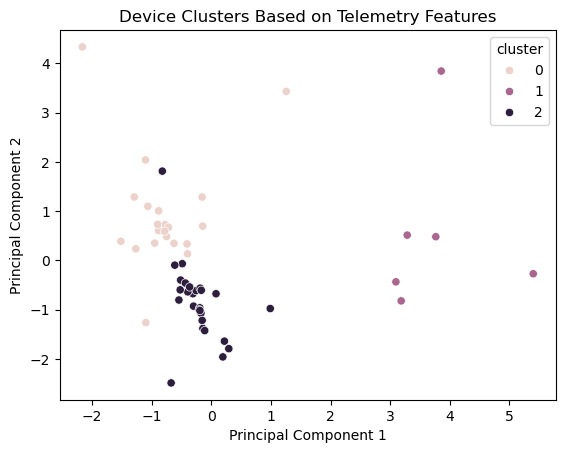

In [302]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example of visualizing clusters with two features
sns.scatterplot(x=df_complete_device_agg['Principal Component 1'], 
                y=df_complete_device_agg['Principal Component 2'], 
                hue=df_complete_device_agg['cluster'])
plt.title('Device Clusters Based on Telemetry Features')
plt.show()

Tenemos entonces 3 clusters de dispositivos. Para cada grupo, voy a tomar el dispositivo con mayor frecuencia de historial de mantenimiento y extrapolar el resultado de su predicción para los otros dispositivos del cluster

### Cluster 0

In [306]:
df_complete_device_agg_0 = df_complete_device_agg[df_complete_device_agg["cluster"] == 0]
df_complete_device_agg_0 = df_complete_device_agg_0.merge(df_valid_device, on = "device", how = "inner")
df_complete_device_agg_0.groupby("device").agg({"failure": "sum", "cluster":"mean", "count": "mean"}).sort_values("failure", ascending = False).sort_values("count", ascending = False)

,failure,cluster,count
device,,,
W1F0T0B1,1,0.0,299.0
Z1F14BGY,1,0.0,282.0
Z1F0MRPJ,1,0.0,230.0
W1F11ZG9,1,0.0,229.0
S1F03YZM,1,0.0,215.0
S1F135TN,1,0.0,211.0
W1F14XGD,1,0.0,209.0
S1F0GPFZ,1,0.0,205.0
S1F0T2LA,1,0.0,204.0


In [308]:
df_device_cluster_0 = df_complete_device[df_complete_device['device'] == 'W1F0T0B1']

In [310]:
df_device_cluster_0

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
8970,2015-01-01,W1F0T0B1,0,188705712,0,0,0,7,201053,0,0,0
8971,2015-01-02,W1F0T0B1,0,208252496,0,0,0,7,202448,0,0,0
8972,2015-01-03,W1F0T0B1,0,229548192,0,0,0,7,203810,0,0,0
8973,2015-01-04,W1F0T0B1,0,16278232,0,0,0,7,205140,0,0,0
8974,2015-01-05,W1F0T0B1,0,35182664,0,0,0,7,206475,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9264,2015-10-22,W1F0T0B1,0,112824920,0,0,0,9,352949,16,16,0
9265,2015-10-23,W1F0T0B1,0,52620456,0,0,0,9,352949,16,16,0
9266,2015-10-24,W1F0T0B1,0,154144032,0,0,0,9,352949,16,16,0
9267,2015-10-25,W1F0T0B1,0,86280056,0,0,7,9,354072,22,22,0


In [312]:
# Rename columns for Prophet
df_device_cluster_0_prophet = df_device_cluster_0[["date", "failure"]].rename(columns={'date': 'ds', 'failure': 'y'})

df_device_cluster_0_prophet.sort_values('ds', inplace=True)

# Display the first few rows
print(df_device_cluster_0_prophet.head())

             ds  y
8970 2015-01-01  0
8971 2015-01-02  0
8972 2015-01-03  0
8973 2015-01-04  0
8974 2015-01-05  0


In [314]:
# Create and fit the Prophet model
model = Prophet()
model.fit(df_device_cluster_0_prophet)

# Create a dataframe for future dates to predict
future = model.make_future_dataframe(periods=7)  # Predict for the next 30 days
forecast = model.predict(future)

14:36:35 - cmdstanpy - INFO - Chain [1] start processing
14:36:36 - cmdstanpy - INFO - Chain [1] done processing


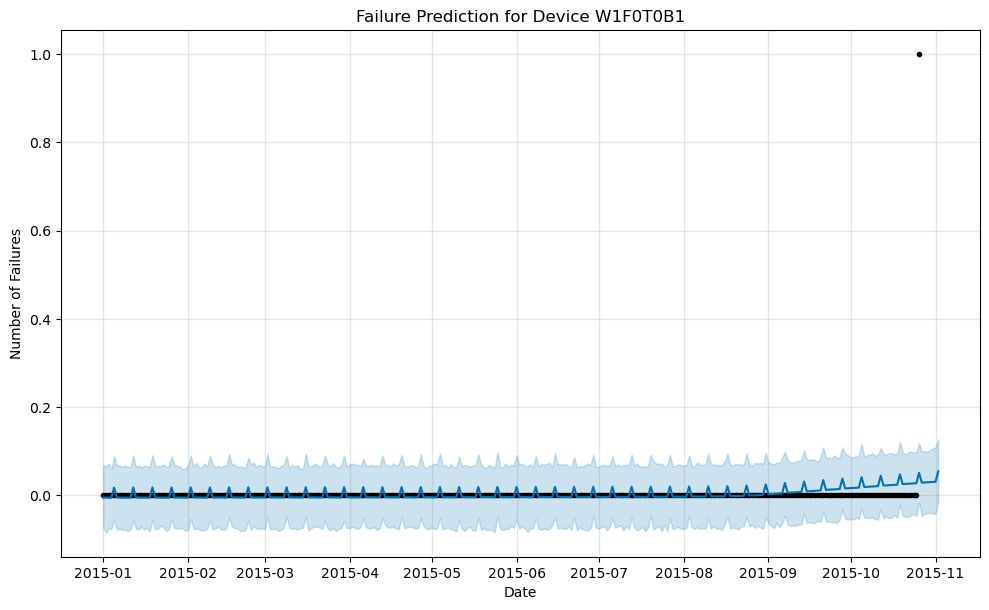

In [316]:
# Plot the forecast
fig = model.plot(forecast)
plt.title(f'Failure Prediction for Device W1F0T0B1')
plt.xlabel('Date')
plt.ylabel('Number of Failures')
plt.show()

In [318]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,-0.001593,-0.072567,0.068906,-0.001593,-0.001593,-0.003172,-0.003172,-0.003172,-0.003172,-0.003172,-0.003172,0.0,0.0,0.0,-0.004765
1,2015-01-02,-0.001584,-0.084464,0.065216,-0.001584,-0.001584,-0.003286,-0.003286,-0.003286,-0.003286,-0.003286,-0.003286,0.0,0.0,0.0,-0.004870
2,2015-01-03,-0.001575,-0.074488,0.071722,-0.001575,-0.001575,-0.003401,-0.003401,-0.003401,-0.003401,-0.003401,-0.003401,0.0,0.0,0.0,-0.004976
3,2015-01-04,-0.001566,-0.075892,0.059291,-0.001566,-0.001566,-0.003516,-0.003516,-0.003516,-0.003516,-0.003516,-0.003516,0.0,0.0,0.0,-0.005082
4,2015-01-05,-0.001556,-0.053889,0.088571,-0.001556,-0.001556,0.019621,0.019621,0.019621,0.019621,0.019621,0.019621,0.0,0.0,0.0,0.018064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,2015-10-29,0.033069,-0.041431,0.098389,0.033067,0.033069,-0.003172,-0.003172,-0.003172,-0.003172,-0.003172,-0.003172,0.0,0.0,0.0,0.029897
302,2015-10-30,0.033537,-0.038692,0.102350,0.033525,0.033545,-0.003286,-0.003286,-0.003286,-0.003286,-0.003286,-0.003286,0.0,0.0,0.0,0.030250
303,2015-10-31,0.034005,-0.041217,0.106744,0.033979,0.034020,-0.003401,-0.003401,-0.003401,-0.003401,-0.003401,-0.003401,0.0,0.0,0.0,0.030604
304,2015-11-01,0.034473,-0.041021,0.109198,0.034434,0.034498,-0.003516,-0.003516,-0.003516,-0.003516,-0.003516,-0.003516,0.0,0.0,0.0,0.030956


Según el modelo, el percentual de falla para los dispositivos del cluster 1 en el dia 02/11/2015 es de 5.4%

### Cluster 1

In [322]:
df_complete_device_agg_1 = df_complete_device_agg[df_complete_device_agg["cluster"] == 1]
df_complete_device_agg_1 = df_complete_device_agg_1.merge(df_valid_device, on = "device", how = "inner")
df_complete_device_agg_1.groupby("device").agg({"failure": "sum", "cluster":"mean", "count": "mean"}).sort_values("failure", ascending = False).sort_values("count", ascending = False)

,failure,cluster,count
device,,,
S1F0JGJV,1,1.0,278.0
W1F1DQN8,1,1.0,212.0
Z1F1653X,1,1.0,128.0
W1F1BZTM,1,1.0,120.0
Z1F148T1,1,1.0,110.0
W1F1CDDP,1,1.0,93.0


In [324]:
# Grupo 2
df_complete_device_agg_2 = df_complete_device_agg[df_complete_device_agg["cluster"] == 2]
df_complete_device_agg_2 = df_complete_device_agg_2.merge(df_valid_device, on = "device", how = "inner")
df_complete_device_agg_2.groupby("device").agg({"failure": "sum", "cluster":"mean", "count": "mean"}).sort_values("failure", ascending = False).sort_values("count", ascending = False)

,failure,cluster,count
device,,,
W1F1CB5E,1,2.0,216.0
S1F0GSHB,1,2.0,215.0
W1F0GCAZ,1,2.0,169.0
W1F0M4BZ,1,2.0,162.0
S1F0QF3R,1,2.0,148.0
S1F0GSD9,1,2.0,148.0
W1F0WBTM,1,2.0,141.0
S1F0L0DW,1,2.0,141.0
S1F0GKL6,1,2.0,133.0


In [326]:
df_device_cluster_1 = df_complete_device[df_complete_device['device'] == 'S1F0JGJV']

In [328]:
# Rename columns for Prophet
df_device_cluster_1_prophet = df_device_cluster_1[["date", "failure"]].rename(columns={'date': 'ds', 'failure': 'y'})

df_device_cluster_1_prophet.sort_values('ds', inplace=True)

# Display the first few rows
print(df_device_cluster_1_prophet.head())

             ds  y
2990 2015-01-01  0
2991 2015-01-02  0
2992 2015-01-03  0
2993 2015-01-04  0
2994 2015-01-05  0


In [330]:
# Create and fit the Prophet model
model = Prophet()
model.fit(df_device_cluster_1_prophet)

# Create a dataframe for future dates to predict
future = model.make_future_dataframe(periods=7)  # Predict for the next 30 days
forecast = model.predict(future)

14:36:39 - cmdstanpy - INFO - Chain [1] start processing
14:36:39 - cmdstanpy - INFO - Chain [1] done processing


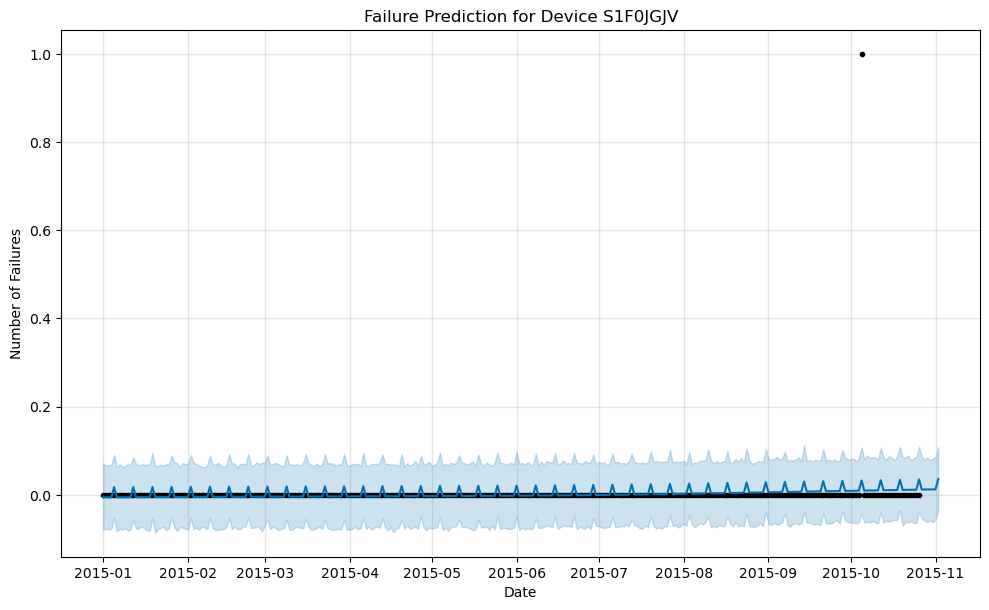

In [332]:
# Plot the forecast
fig = model.plot(forecast)
plt.title(f'Failure Prediction for Device S1F0JGJV')
plt.xlabel('Date')
plt.ylabel('Number of Failures')
plt.show()

In [334]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,-0.002267,-0.079108,0.071910,-0.002267,-0.002267,-0.003214,-0.003214,-0.003214,-0.003214,-0.003214,-0.003214,0.0,0.0,0.0,-0.005480
1,2015-01-02,-0.002244,-0.076827,0.066096,-0.002244,-0.002244,-0.003272,-0.003272,-0.003272,-0.003272,-0.003272,-0.003272,0.0,0.0,0.0,-0.005516
2,2015-01-03,-0.002222,-0.078510,0.067249,-0.002222,-0.002222,-0.003331,-0.003331,-0.003331,-0.003331,-0.003331,-0.003331,0.0,0.0,0.0,-0.005553
3,2015-01-04,-0.002200,-0.076105,0.068315,-0.002200,-0.002200,-0.003390,-0.003390,-0.003390,-0.003390,-0.003390,-0.003390,0.0,0.0,0.0,-0.005589
4,2015-01-05,-0.002177,-0.052370,0.090510,-0.002177,-0.002177,0.019725,0.019725,0.019725,0.019725,0.019725,0.019725,0.0,0.0,0.0,0.017548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,2015-10-29,0.015453,-0.061362,0.085026,0.015452,0.015454,-0.003214,-0.003214,-0.003214,-0.003214,-0.003214,-0.003214,0.0,0.0,0.0,0.012239
302,2015-10-30,0.015563,-0.058769,0.078938,0.015561,0.015566,-0.003272,-0.003272,-0.003272,-0.003272,-0.003272,-0.003272,0.0,0.0,0.0,0.012291
303,2015-10-31,0.015674,-0.061646,0.081502,0.015670,0.015680,-0.003331,-0.003331,-0.003331,-0.003331,-0.003331,-0.003331,0.0,0.0,0.0,0.012343
304,2015-11-01,0.015785,-0.055718,0.086150,0.015778,0.015793,-0.003390,-0.003390,-0.003390,-0.003390,-0.003390,-0.003390,0.0,0.0,0.0,0.012395


De acuerdo con el modelo, el percentual de falla para los dispositivos del cluster 1 en el dia 02/11/2015 es de 3.5%

### Cluster 2

In [338]:
df_device_cluster_2 = df_complete_device[df_complete_device['device'] == 'W1F1CB5E']

In [340]:
# Rename columns for Prophet
df_device_cluster_2_prophet = df_device_cluster_2[["date", "failure"]].rename(columns={'date': 'ds', 'failure': 'y'})

df_device_cluster_2_prophet.sort_values('ds', inplace=True)

# Display the first few rows
print(df_device_cluster_2_prophet.head())

              ds  y
11661 2015-01-01  0
11662 2015-01-02  0
11663 2015-01-03  0
11664 2015-01-04  0
11665 2015-01-05  0


In [342]:
# Create and fit the Prophet model
model = Prophet()
model.fit(df_device_cluster_2_prophet)

# Create a dataframe for future dates to predict
future = model.make_future_dataframe(periods=7)  # Predict for the next 30 days
forecast = model.predict(future)

14:36:42 - cmdstanpy - INFO - Chain [1] start processing
14:36:42 - cmdstanpy - INFO - Chain [1] done processing


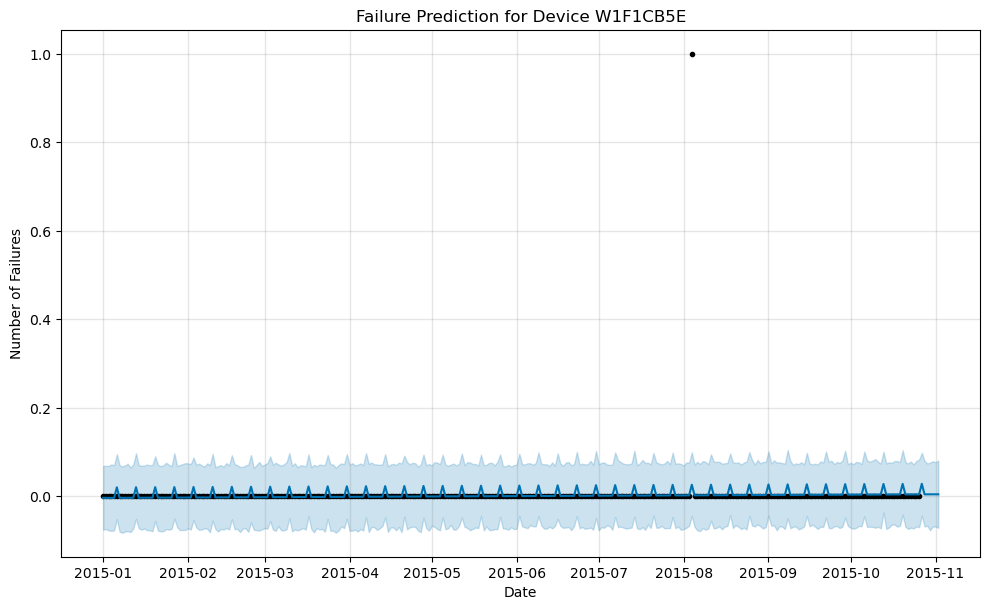

In [344]:
# Plot the forecast
fig = model.plot(forecast)
plt.title(f'Failure Prediction for Device W1F1CB5E')
plt.xlabel('Date')
plt.ylabel('Number of Failures')
plt.show()

In [346]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,-0.000592,-0.075690,0.068732,-0.000592,-0.000592,-0.003357,-0.003357,-0.003357,-0.003357,-0.003357,-0.003357,0.0,0.0,0.0,-0.003949
1,2015-01-02,-0.000564,-0.074539,0.068563,-0.000564,-0.000564,-0.003383,-0.003383,-0.003383,-0.003383,-0.003383,-0.003383,0.0,0.0,0.0,-0.003947
2,2015-01-03,-0.000537,-0.077487,0.068391,-0.000537,-0.000537,-0.003408,-0.003408,-0.003408,-0.003408,-0.003408,-0.003408,0.0,0.0,0.0,-0.003945
3,2015-01-04,-0.000509,-0.078424,0.071776,-0.000509,-0.000509,-0.003434,-0.003434,-0.003434,-0.003434,-0.003434,-0.003434,0.0,0.0,0.0,-0.003943
4,2015-01-05,-0.000482,-0.077436,0.069936,-0.000482,-0.000482,-0.003459,-0.003459,-0.003459,-0.003459,-0.003459,-0.003459,0.0,0.0,0.0,-0.003941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,2015-10-29,0.007519,-0.066826,0.073989,0.007519,0.007519,-0.003357,-0.003357,-0.003357,-0.003357,-0.003357,-0.003357,0.0,0.0,0.0,0.004161
302,2015-10-30,0.007544,-0.077284,0.075697,0.007544,0.007545,-0.003383,-0.003383,-0.003383,-0.003383,-0.003383,-0.003383,0.0,0.0,0.0,0.004162
303,2015-10-31,0.007570,-0.068881,0.078915,0.007570,0.007570,-0.003408,-0.003408,-0.003408,-0.003408,-0.003408,-0.003408,0.0,0.0,0.0,0.004162
304,2015-11-01,0.007596,-0.068873,0.076667,0.007596,0.007596,-0.003434,-0.003434,-0.003434,-0.003434,-0.003434,-0.003434,0.0,0.0,0.0,0.004162


De acuerdo con el modelo, el percentual de falla para los dispositivos del cluster 2 en el dia 02/11/2015 es de 0.4%